In [38]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import loadmat
%matplotlib inline

from transparent_background import Remover 
import cv2
from PIL import Image
import time
import os

In [39]:
base_path = "./dataset/"

# directories
train_images_dir = os.path.join(base_path, "images/train")
test_images_dir = os.path.join(base_path, "images/test")

train_labels_dir = os.path.join(base_path, "labels/train")
test_labels_dir = os.path.join(base_path, "labels/test")

# mat files
train_annos = os.path.join(base_path, "cars_train_annos.mat")
test_annos = os.path.join(base_path, "cars_test_annos_withlabels.mat")
meta_path = os.path.join(base_path, "cars_meta.mat")

## Dataset Setup

In [40]:
def convert_annotations(mat_file, images_dir, labels_dir):
    annos = loadmat(mat_file)['annotations'][0]
    os.makedirs(labels_dir, exist_ok=True)

    for anno in annos:
        bbox_x1 = int(anno[0][0][0])
        bbox_y1 = int(anno[1][0][0])
        bbox_x2 = int(anno[2][0][0])
        bbox_y2 = int(anno[3][0][0])
        class_id = int(anno[4][0][0]) - 1  # Zero-based indexing
        filename = anno[5][0]
        image_path = os.path.join(images_dir, filename)
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        x_center = ((bbox_x1 + bbox_x2) / 2) / w
        y_center = ((bbox_y1 + bbox_y2) / 2) / h
        width = (bbox_x2 - bbox_x1) / w
        height = (bbox_y2 - bbox_y1) / h

        label_path = os.path.join(labels_dir, f"{os.path.splitext(filename)[0]}.txt")
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [41]:
class StanfordCarsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_path, meta_path, mode="train", transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        
        # Load annotations and class names
        self.annotations = loadmat(annotations_path)["annotations"][0]
        self.class_names = [c[0] for c in loadmat(meta_path)["class_names"][0]]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        anno = self.annotations[idx]
        
        # Extract filename, bbox, and class
        img_name = anno[-1][0]
        bbox_x1 = list(anno[0][0])[0]
        bbox_y1 = list(anno[1][0])[0]
        bbox_x2 = list(anno[2][0])[0]
        bbox_y2 = list(anno[3][0])[0]
        class_label = list(anno[4][0])[0] - 1  # Zero-based indexing

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        bbox = (bbox_x1, bbox_y1, bbox_x2, bbox_y2)
        return image, bbox, class_label
    
    def getImagePath(self, idx):
        anno = self.annotations[idx]
        return os.path.join(self.root_dir, anno[-1][0])
    

In [42]:
train_dataset = StanfordCarsDataset(root_dir=train_images_dir,
                                    annotations_path=train_annos,
                                    meta_path=meta_path,
                                    mode="train",
                                    transform=None
                                   )

test_dataset = StanfordCarsDataset(root_dir=test_images_dir,
                                    annotations_path=test_annos,
                                    meta_path=meta_path,
                                    mode="test",
                                    transform=None
                                   )

## Architectures

#### InSPyReNet

In [43]:
remover = Remover(mode='fast')

Settings -> Mode=fast, Device=mps:0, Torchscript=disabled


## Processing Functions

In [70]:
# This one is sorta working
def predict_car_color(image, bbox):
    image = image.convert("RGB")
    img_width, img_height = image.size
    
    # Clip bounding box coordinates
    x1 = max(0, min(bbox[0], img_width))
    y1 = max(0, min(bbox[1], img_height))
    x2 = max(0, min(bbox[2], img_width))
    y2 = max(0, min(bbox[3], img_height))
    
    cropped_img = image.crop((x1, y1, x2, y2))
    original_size = cropped_img.size
    
    # Apply median filter and bilateral filter for noise reduction
    cropped_np = cv2.medianBlur(np.array(cropped_img), 5)
    cropped_np = cv2.bilateralFilter(cropped_np, 9, 75, 75)
    
    # Process with background remover
    processed_img = remover.process(Image.fromarray(cropped_np).resize((256, 256)), type='rgba')
    processed_resized = processed_img.resize(original_size)
    processed_array = np.array(processed_resized)
    
    # Create mask
    if processed_img.mode == 'RGBA':
        mask = np.array(processed_img.getchannel('A').resize(original_size, Image.NEAREST)) > 200  # Higher threshold
    else:
        mask = np.ones((original_size[1], original_size[0]), dtype=bool)
    
    # Convert to HSV and analyze dominant hue
    hsv_array = cv2.cvtColor(processed_array[..., :3], cv2.COLOR_RGB2HSV)
    hue_values = hsv_array[..., 0][mask]
    
    # Find dominant hue using histogram
    hist = np.histogram(hue_values, bins=20, range=(0, 180))[0]
    dominant_bin = np.argmax(hist)
    hue_range = (dominant_bin*9, (dominant_bin+1)*9)  # 20 bins = 9° per bin
    
    # Create refined mask for dominant hues
    hue_mask = (hsv_array[..., 0] >= hue_range[0]) & (hsv_array[..., 0] <= hue_range[1])
    combined_mask = mask & hue_mask
    
    # Fallback to original mask if no dominant pixels
    if np.sum(combined_mask) == 0:
        combined_mask = mask
    
    # Calculate median from refined area
    rgb_array = processed_array[..., :3]
    car_pixels = rgb_array[combined_mask]
    
    if car_pixels.size == 0:
        car_pixels = rgb_array.reshape(-1, 3)
    
    median_color = np.median(car_pixels, axis=0).astype(int)
    return median_color

In [71]:
# def predict_car_color(image, bbox):
#     image = image.convert("RGB")
#     img_width, img_height = image.size
    
#     # Clip bounding box coordinates
#     x1, y1, x2, y2 = (max(0, min(coord, dim)) for coord, dim in zip(bbox, [img_width, img_height]*2))
#     cropped_img = image.crop((x1, y1, x2, y2))
#     original_size = cropped_img.size
    
#     # Preprocessing with enhanced denoising
#     cropped_np = cv2.medianBlur(np.array(cropped_img), 7)
#     cropped_np = cv2.bilateralFilter(cropped_np, 11, 150, 150)
    
#     # Process with background remover and ensure RGB format
#     processed_img = remover.process(Image.fromarray(cropped_np).convert("RGBA"))
#     processed_array = np.array(processed_img.resize(original_size))
    
#     # Convert to RGB with explicit channel order validation
#     rgb_array = cv2.cvtColor(processed_array[..., :3], cv2.COLOR_RGBA2RGB)
    
#     # Convert to HSV and handle red hue continuity
#     hsv_array = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2HSV)
#     hue = hsv_array[..., 0].astype(np.float32)
    
#     # Create strict mask with dilation
#     mask = (np.array(processed_img.getchannel('A').resize(original_size, Image.NEAREST)) > 220).astype(np.uint8)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    
#     # Handle red hue wrap-around using circular statistics
#     hue_rad = np.deg2rad(hue[mask.astype(bool)] * 2)  # Double angle for circular continuity
#     median_cos = np.median(np.cos(hue_rad))
#     median_sin = np.median(np.sin(hue_rad))
#     median_hue = np.rad2deg(np.arctan2(median_sin, median_cos)) % 180
    
#     # Calculate saturation and value
#     median_sat = np.median(hsv_array[..., 1][mask.astype(bool)])
#     median_val = np.median(hsv_array[..., 2][mask.astype(bool)])
    
#     # Chromatic/achromatic determination
#     if median_sat < 25:
#         if median_val > 200: return "White", (255, 255, 255)
#         elif median_val > 100: return "Gray", (128, 128, 128)
#         else: return "Black", (0, 0, 0)
#     else:
#         # Hue correction for red dominance
#         if 170 < median_hue < 190:
#             median_hue = 0
        
#         # Convert final HSV to RGB
#         normalized_hsv = (int(median_hue), int(median_sat), int(median_val * 0.9 + 50))
#         rgb_color = cv2.cvtColor(np.array([[normalized_hsv]], dtype=np.uint8), cv2.COLOR_HSV2RGB)[0][0]
#         return f"H: {median_hue:.1f}°", tuple(rgb_color.tolist())

In [74]:
def visualize_prediction(idx, dataset):
    # Retrieve data
    image, bbox, class_id = dataset[idx]
    
    # Predict color
    rgb_color = predict_car_color(image, bbox)
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image with bounding box
    axes[0].imshow(image)
    x1, y1, x2, y2 = bbox
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axes[0].add_patch(rect)
    axes[0].set_title(f"Original Image: {idx}")
    axes[0].axis('off')
    
    # Display color
    color_patch = np.ones((100, 100, 3), dtype=np.uint8) * rgb_color
    axes[1].imshow(color_patch)
#     axes[1].set_title(f"Detected Color\n{color_label}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return rgb_color

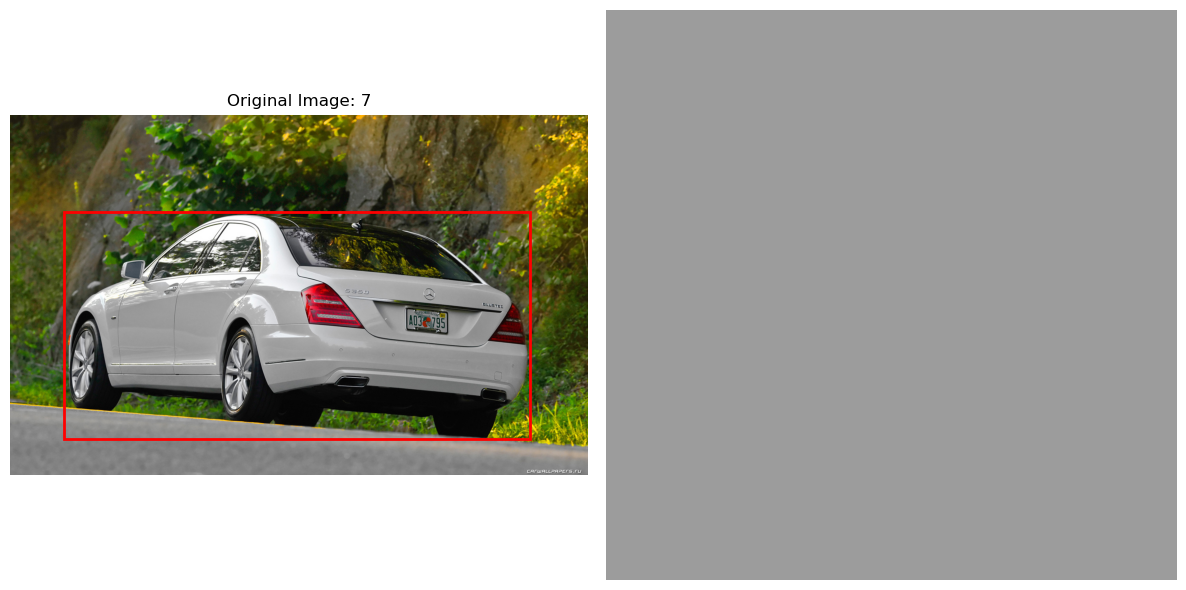

array([156, 156, 156])

In [79]:
visualize_prediction(7,test_dataset)

In [47]:
imgtest, bbox, _ = test_dataset[1]
imgtest = imgtest.convert("RGB")

In [48]:
img_width, img_height = imgtest.size

x1 = max(0, min(bbox[0], img_width))
y1 = max(0, min(bbox[1], img_height))
x2 = max(0, min(bbox[2], img_width))
y2 = max(0, min(bbox[3], img_height))

cropped_img = imgtest.crop((x1, y1, x2, y2))
original_size = cropped_img.size

In [49]:
cropped_np = cv2.medianBlur(np.array(cropped_img), 5)

In [50]:
processed_img = remover.process(Image.fromarray(cropped_np).resize((256, 256)), type='rgba')

In [51]:
processed_resized = processed_img.resize(original_size)

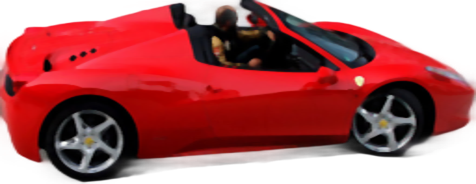

In [52]:
processed_resized

In [53]:
mask = np.array(processed_img.getchannel('A').resize(original_size, Image.NEAREST)) > 200  # Higher threshold

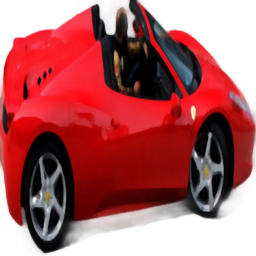

In [54]:
processed_img

In [55]:
mask = np.ones((original_size[1], original_size[0]), dtype=bool)

In [56]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])